## Setup

In [153]:
!pip install pytorch-nlp
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import numpy as np

In [154]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Download dataset and prepare `DataLoader`s

In [155]:
BATCH_SIZE = 64
epochs = 45
lr = 0.0003

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

tset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                       download=True, transform=transform)
valset, testset = random_split(tset, [len(tset)//2, len(tset)//2])
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)
CLASS_NAMES = ("plane", "car", "bird", "cat",
               "deer", "dog", "frog", "horse", "ship", "truck")
print(len(trainloader), len(valloader), len(testloader))

Files already downloaded and verified
Files already downloaded and verified
782 79 79


# Define training

In [156]:
def train(model, device, train_loader, optimizer, criterion):
  # Switch model to training mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
  model.train()

  train_loss = 0
  train_total = 0
  train_correct = 0

  # We loop over the data iterator, and feed the inputs to the network and adjust the weights.
  for batch_idx, (data, target) in enumerate(train_loader, start=0):
    
    # Load the input features and labels from the training dataset
    data, target = data.to(device), target.to(device)
    
    # Reset the gradients to 0 for all learnable weight parameters
    optimizer.zero_grad()
    
    # Forward pass: Pass image data from training dataset, make predictions about class image belongs to (0-9 in this case)
    output = model(data)
    
    # Define our loss function, and compute the loss
    loss = criterion(output, target)
    train_loss += loss.item()

    scores, predictions = torch.max(output.data, 1)
    train_total += target.size(0)
    train_correct += int(sum(predictions == target))
            
    # Reset the gradients to 0 for all learnable weight parameters
    optimizer.zero_grad()

    # Backward pass: compute the gradients of the loss w.r.t. the model"s parameters
    loss.backward()
    
    # Update the neural network weights
    optimizer.step()

  acc = round((train_correct / train_total) * 100, 2)
  return train_loss/train_total, acc
  

# Define testing

In [157]:
def test(model, device, data_loader, criterion):
  # Switch model to evaluation mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
  model.eval()

  loss = 0
  total = 0
  correct = 0

  example_images = []
  with torch.no_grad():
      for data, target in data_loader:
          # Load the input features and labels from the test dataset
          data, target = data.to(device), target.to(device)
          
          # Make predictions: Pass image data from test dataset, make predictions about class image belongs to (0-9 in this case)
          output = model(data)
          
          # Compute the loss sum up batch loss
          loss += criterion(output, target).item()
          
          scores, predictions = torch.max(output.data, 1)
          total += target.size(0)
          correct += int(sum(predictions == target))

  acc = round((correct / total) * 100, 2)
  return loss/total, acc, 
 


# Define Train_Model

In [158]:
def train_model(net, device, optimizer, criterion, epochs):
  train_losses = []
  val_losses = []
  test_losses = []
  train_accs = []
  val_accs = []
  test_accs = []
  for epoch in range(epochs):
    train_loss, train_acc = train(net, device, trainloader, optimizer, criterion)
    print("Epochs:{}/{}, Train_loss: {}, Train_accuracy: {}".format(epoch+1, epochs, train_loss, train_acc))
    val_loss, val_acc = test(net, device, valloader, criterion)
    print(" Val_loss: {}, Val_accuracy: {}".format(val_loss, val_acc))
    test_loss, test_acc = test(net, device, testloader, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
  print("Finished Training")
  min_test_loss = min(val_losses)
  max_test_acc = max(val_accs)
  index1 = val_losses.index(min_test_loss)
  index2 = val_accs.index(max_test_acc)
  print("The minimum validation loss is {}, at epoch {}".format(min_test_loss, index1+1))
  print("At epoch {}, the test loss is {}, the test accuracy is {}".format(index1+1, test_losses[index1], test_accs[index1]))
  print("The maximum validation accuracy is {}, at epoch {}".format(max_test_acc, index2+1))
  print("At epoch {}, the test loss is {}, the test accuracy is {}".format(index2+1, test_losses[index2], test_accs[index2]))
  return train_losses, train_accs, val_losses, val_accs

# Training the unregularized model

In [159]:
class Net(nn.Module):
  def __init__(self, input_shape=(3,32,32)):
    super(Net, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv3 = nn.Conv2d(64, 128, 3)
    
    self.pool = nn.MaxPool2d(2,2)

    n_size = self._get_conv_output(input_shape)
    
    self.fc1 = nn.Linear(n_size, 512)
    self.fc2 = nn.Linear(512, 10)

  def _get_conv_output(self, shape):
    batch_size = 1
    input = torch.autograd.Variable(torch.rand(batch_size, *shape))
    output_feat = self._forward_features(input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size

  def _forward_features(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    return x
      
  def forward(self, x):
    x = self._forward_features(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

#### Initialize Model, Loss and Optimizer

In [160]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

#### Train

In [161]:
train_losses1, train_accs1, val_losses1, val_accs1 = train_model(net, device, optimizer, criterion, epochs)

Epochs:1/45, Train_loss: 0.025839245343208313, Train_accuracy: 39.15
 Val_loss: 0.022143758034706116, Val_accuracy: 49.48
Epochs:2/45, Train_loss: 0.020779057879447938, Train_accuracy: 51.96
 Val_loss: 0.01944654949903488, Val_accuracy: 56.06
Epochs:3/45, Train_loss: 0.01846092041373253, Train_accuracy: 57.92
 Val_loss: 0.017992432534694673, Val_accuracy: 59.26
Epochs:4/45, Train_loss: 0.016664605741500853, Train_accuracy: 62.39
 Val_loss: 0.016987479245662688, Val_accuracy: 62.42
Epochs:5/45, Train_loss: 0.015330710889101028, Train_accuracy: 65.52
 Val_loss: 0.01582172962427139, Val_accuracy: 64.54
Epochs:6/45, Train_loss: 0.014277414486408234, Train_accuracy: 68.09
 Val_loss: 0.015111890280246735, Val_accuracy: 66.24
Epochs:7/45, Train_loss: 0.013283113009929657, Train_accuracy: 70.3
 Val_loss: 0.014336541676521302, Val_accuracy: 67.94
Epochs:8/45, Train_loss: 0.012464440585970878, Train_accuracy: 72.23
 Val_loss: 0.013789914286136627, Val_accuracy: 69.38
Epochs:9/45, Train_loss: 0.0

# Training a model with dropout regularization

In [162]:
class Net(nn.Module):
  def __init__(self, input_shape=(3,32,32)):
    super(Net, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv3 = nn.Conv2d(64, 128, 3)
    
    self.pool = nn.MaxPool2d(2,2)

    n_size = self._get_conv_output(input_shape)
    
    self.fc1 = nn.Linear(n_size, 512)
    self.fc2 = nn.Linear(512, 10)

    self.dropout = nn.Dropout(0.5)

  def _get_conv_output(self, shape):
    batch_size = 1
    input = torch.autograd.Variable(torch.rand(batch_size, *shape))
    output_feat = self._forward_features(input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size

  def _forward_features(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    return x
      
  def forward(self, x):
    x = self._forward_features(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

#### Initialize Model, Loss and Optimizer

In [163]:
net = Net().to(device)
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


#### Train

In [164]:
train_losses2, train_accs2, val_losses2, val_accs2 = train_model(net, device, optimizer, criterion, epochs)

Epochs:1/45, Train_loss: 0.02657002835512161, Train_accuracy: 37.06
 Val_loss: 0.02269824471473694, Val_accuracy: 47.26
Epochs:2/45, Train_loss: 0.02180830277442932, Train_accuracy: 49.29
 Val_loss: 0.020056264567375182, Val_accuracy: 54.6
Epochs:3/45, Train_loss: 0.019429156613349916, Train_accuracy: 55.32
 Val_loss: 0.018209161293506623, Val_accuracy: 59.5
Epochs:4/45, Train_loss: 0.017835536661148073, Train_accuracy: 59.54
 Val_loss: 0.017423691630363464, Val_accuracy: 61.08
Epochs:5/45, Train_loss: 0.016563281922340394, Train_accuracy: 62.57
 Val_loss: 0.016151072943210602, Val_accuracy: 63.66
Epochs:6/45, Train_loss: 0.015459253511428833, Train_accuracy: 65.1
 Val_loss: 0.015457818186283112, Val_accuracy: 65.22
Epochs:7/45, Train_loss: 0.014500097019672394, Train_accuracy: 67.44
 Val_loss: 0.015016126251220703, Val_accuracy: 66.14
Epochs:8/45, Train_loss: 0.013707030822038651, Train_accuracy: 69.35
 Val_loss: 0.014458741009235382, Val_accuracy: 67.2
Epochs:9/45, Train_loss: 0.0129

# Training with dropconnect regularization

Define DropConnect

In [165]:
from torch.nn import Parameter
def _weight_drop(module, weight, dropout):
    """
    Helper for `WeightDrop`.
    """

    
    w = getattr(module, weight)
    del module._parameters[weight]
    module.register_parameter(weight + '_raw', Parameter(w))

    original_module_forward = module.forward

    def forward(*args, **kwargs):
        raw_w = getattr(module, weight + '_raw')
        w = torch.nn.functional.dropout(raw_w, p=dropout, training=module.training)
        setattr(module, weight, Parameter(w))

        return original_module_forward(*args, **kwargs)

    setattr(module, 'forward', forward)
class WeightDropLinear1(torch.nn.Linear):
    """
    Wrapper around :class:`torch.nn.Linear` that adds ``weight_dropout`` named argument.

    Args:
        weight_dropout (float): The probability a weight will be dropped.
    """

    def __init__(self, *args, weight_dropout=0.0, **kwargs):
        super().__init__(*args, **kwargs)
        weights = 'weight'
        _weight_drop(self, weights, weight_dropout)

In [166]:
class Net(nn.Module):
  def __init__(self, input_shape=(3,32,32)):
    super(Net, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv3 = nn.Conv2d(64, 128, 3)
    
    self.pool = nn.MaxPool2d(2,2)

    n_size = self._get_conv_output(input_shape)
    self.wd1 = WeightDropLinear1(in_features=n_size, out_features=n_size, weight_dropout=0.5)
    self.fc1 = nn.Linear(n_size, 512)
    self.fc2 = nn.Linear(512, 10)

  def _get_conv_output(self, shape):
    batch_size = 1
    input = torch.autograd.Variable(torch.rand(batch_size, *shape))
    output_feat = self._forward_features(input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size

  def _forward_features(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    return x
      
  def forward(self, x):
    x = self._forward_features(x)
    x = x.view(x.size(0), -1)
    x = self.wd1(x)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [167]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

Training

In [168]:
train_losses3, train_accs3, val_losses3, val_accs3 = train_model(net, device, optimizer, criterion, epochs)

Epochs:1/45, Train_loss: 0.027298289301395415, Train_accuracy: 34.9
 Val_loss: 0.024051397204399107, Val_accuracy: 43.52
Epochs:2/45, Train_loss: 0.022777891376018523, Train_accuracy: 46.45
 Val_loss: 0.02091338367462158, Val_accuracy: 51.5
Epochs:3/45, Train_loss: 0.020521777005195616, Train_accuracy: 52.29
 Val_loss: 0.019188994336128234, Val_accuracy: 56.32
Epochs:4/45, Train_loss: 0.01891555255293846, Train_accuracy: 56.47
 Val_loss: 0.0175674192905426, Val_accuracy: 60.14
Epochs:5/45, Train_loss: 0.017618438407182694, Train_accuracy: 60.01
 Val_loss: 0.016506905329227446, Val_accuracy: 62.66
Epochs:6/45, Train_loss: 0.016497956236600875, Train_accuracy: 62.44
 Val_loss: 0.015912002992630004, Val_accuracy: 63.66
Epochs:7/45, Train_loss: 0.015626084941625595, Train_accuracy: 64.43
 Val_loss: 0.014953514659404754, Val_accuracy: 66.4
Epochs:8/45, Train_loss: 0.014768752777576447, Train_accuracy: 66.55
 Val_loss: 0.014620038175582885, Val_accuracy: 67.3
Epochs:9/45, Train_loss: 0.01408

# Training with dropblock regularization

In [169]:
import torch
import torch.nn.functional as F
from torch import nn


class DropBlock2D(nn.Module):
    r"""Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)


class DropBlock3D(DropBlock2D):
    r"""Randomly zeroes 3D spatial blocks of the input tensor.
    An extension to the concept described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, D, H, W)`
        - Output: `(N, C, D, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock3D, self).__init__(drop_prob, block_size)

    def forward(self, x):
        # shape: (bsize, channels, depth, height, width)

        assert x.dim() == 5, \
            "Expected input with 5 dimensions (bsize, channels, depth, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool3d(input=mask[:, None, :, :, :],
                                  kernel_size=(self.block_size, self.block_size, self.block_size),
                                  stride=(1, 1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 3)

In [170]:
import numpy as np
from torch import nn


class LinearScheduler(nn.Module):
    def __init__(self, dropblock, start_value, stop_value, nr_steps):
        super(LinearScheduler, self).__init__()
        self.dropblock = dropblock
        self.i = 0
        self.drop_values = np.linspace(start=start_value, stop=stop_value, num=int(nr_steps))

    def forward(self, x):
        return self.dropblock(x)

    def step(self):
        if self.i < len(self.drop_values):
            self.dropblock.drop_prob = self.drop_values[self.i]

        self.i += 1

In [171]:
class Net(nn.Module):
  def __init__(self, input_shape=(3,32,32)):
    super(Net, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv3 = nn.Conv2d(64, 128, 3)
    
    self.pool = nn.MaxPool2d(2,2)

    n_size = self._get_conv_output(input_shape)
    
    self.fc1 = nn.Linear(n_size, 512)
    self.fc2 = nn.Linear(512, 10)
    self.dropblock = LinearScheduler(
            DropBlock2D(drop_prob=0.5, block_size=3),
            start_value=0.,
            stop_value=0.5,
            nr_steps=5e3
        )

  def _get_conv_output(self, shape):
    batch_size = 1
    input = torch.autograd.Variable(torch.rand(batch_size, *shape))
    output_feat = self._forward_features(input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size

  def _forward_features(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    return x
      
  def forward(self, x):
    self.dropblock.step()
    x = self.pool(F.relu(self.conv1(x)))
    x = self.conv2(x)
    x = self.pool(F.relu(self.dropblock(x)))
    x = self.conv3(x)
    x = self.pool(F.relu(x))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [172]:
net = Net().to(device)
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropblock): LinearScheduler(
    (dropblock): DropBlock2D()
  )
)


In [173]:
train_losses4, train_accs4, val_losses4, val_accs4 = train_model(net, device, optimizer, criterion, epochs)

Epochs:1/45, Train_loss: 0.026013869414329528, Train_accuracy: 39.25
 Val_loss: 0.021838506698608397, Val_accuracy: 49.84
Epochs:2/45, Train_loss: 0.020772363709211348, Train_accuracy: 52.09
 Val_loss: 0.019571615397930144, Val_accuracy: 55.76
Epochs:3/45, Train_loss: 0.01872313467979431, Train_accuracy: 57.37
 Val_loss: 0.01727901816368103, Val_accuracy: 62.18
Epochs:4/45, Train_loss: 0.01726429188847542, Train_accuracy: 61.01
 Val_loss: 0.01661249840259552, Val_accuracy: 63.56
Epochs:5/45, Train_loss: 0.016214344009160997, Train_accuracy: 63.51
 Val_loss: 0.016072977697849274, Val_accuracy: 65.12
Epochs:6/45, Train_loss: 0.01565373354792595, Train_accuracy: 64.81
 Val_loss: 0.015039219439029694, Val_accuracy: 67.94
Epochs:7/45, Train_loss: 0.014804356726408004, Train_accuracy: 66.92
 Val_loss: 0.014681025743484497, Val_accuracy: 67.58
Epochs:8/45, Train_loss: 0.01407848020195961, Train_accuracy: 68.32
 Val_loss: 0.01400851867198944, Val_accuracy: 70.44
Epochs:9/45, Train_loss: 0.0132

# Graph the Results

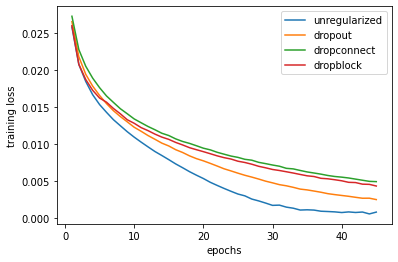

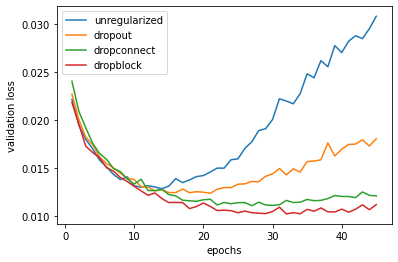

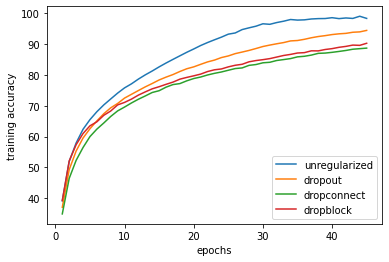

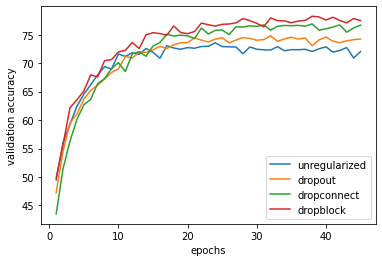

In [174]:
import matplotlib.pyplot as plt

x = range(1,epochs+1)
plt.plot(x, train_losses1, label="unregularized")
plt.xlabel("epochs")
plt.plot(x, train_losses2, label="dropout")
plt.plot(x, train_losses3, label="dropconnect")
plt.plot(x, train_losses4, label="dropblock")
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.legend()
plt.show()

plt.plot(x, val_losses1, label="unregularized")
plt.plot(x, val_losses2, label="dropout")
plt.plot(x, val_losses3, label="dropconnect")
plt.plot(x, val_losses4, label="dropblock")

plt.xlabel("epochs")
plt.ylabel("validation loss")
plt.legend()
plt.show()

plt.plot(x, train_accs1, label='unregularized')
plt.plot(x, train_accs2, label='dropout')
plt.plot(x, train_accs3, label='dropconnect')
plt.plot(x, train_accs4, label="dropblock")

plt.xlabel("epochs")
plt.ylabel("training accuracy")
plt.legend()
plt.show()

plt.plot(x, val_accs1, label='unregularized')
plt.plot(x, val_accs2, label='dropout')
plt.plot(x, val_accs3, label='dropconnect')
plt.plot(x, val_accs4, label="dropblock")

plt.xlabel("epochs")
plt.ylabel("validation accuracy")
plt.legend()
plt.show()